## Compute all panels for Figure 3,4,5,6,7,9,10,11 and the list of best features used for Figure 9
<p>Sensor ID are different from the ones used in the manuscript, please refer to the chart at the end of this notebook
</p>

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import glob
%matplotlib inline

In [9]:
# Enter your directory
base = '/directory/' 

#Wpaths = result folder for window length analysis
Wpaths = 'window_length_results/'
#paths = result folder for the configuration / feature number analysis
paths = ['config_feat_results/']
#npaths = result folder for single forest selected exemples
npaths = ['one_config/']

baseWindows = [str(base+Wpaths)]
print(baseWindows)
print(base,paths)
print(base,npaths)
print('done')

C:\Users\julien\Desktop\20-sec-final\ ['v3_final20s\\']
C:\Users\julien\Desktop\20-sec-final\ ['one_config_v2\\']
done


## Functions for extracting results data from the machine learning step

In [10]:
#combine files into one
def combinefiles(basename,maxnumber):
    data = pd.DataFrame()
    for i in range(1,maxnumber+1):
        dat2 = pd.read_csv(basename+'_'+str(i)+'.csv',index_col=0,names=[str(i)],skiprows=1)
        data = pd.concat([data,dat2],axis=1)
    return data.T

#Get all data for a given set of sensor configurations, or optionally up to maxFeatures features
def getAllData(path, configurations,maxFeatures=None):
    all_dat = []
    maxVal = maxFeatures
    for e in configurations:
        if not maxFeatures:
            maxVal = len(glob.glob(path+e+'_'+'*features.csv')) #should be same as base
        dat = combinefiles(path+e,maxVal)
        dat["id"] = dat.index
        test = pd.melt(dat,id_vars=["id"])
        all_dat.append(test)
    return pd.concat(all_dat,keys=configurations,names=['Series', 'Row ID'])

#extract statistics from evaluations
def getStats(data,basename):
    adapted = data.groupby(['Series',basename]).agg({'value':['min','mean','max']}).unstack('Series') # for each value of the 0th collumn, find the min, mean and max
    adapted.index = adapted.index.astype(int)
    adapted = adapted.sort_index()
    return adapted

#get the frequency of features for a given sensor combination when only nFeatures are available
def getNFeatures(path,sensors,nFeatures):
    feature_read = pd.read_csv(path+(" ".join([str(i) for i in sensors]))+'_'+str(nFeatures)+'features.csv')
    tmpArray = feature_read.columns.to_numpy()
    tmpArray[0] = 'Available'
    feature_read.columns = tmpArray
    feature_read.loc[0:0,('Available')] = nFeatures
    return feature_read

#combine together all feature frequency evaluations for a given sensor combination, or optionally up to maxFeatures
def getAllFeatures(path,sensors,maxFeatures=None, index_name = 'Available'):
    df = pd.DataFrame()
    if not maxFeatures:
        maxFeatures = len(glob.glob(path+(" ".join([str(i) for i in sensors]))+'_'+'*features.csv'))
    for i in range(maxFeatures,0,-1):
        df = pd.concat([df,getNFeatures(path,sensors,i)], axis=0, ignore_index=True, sort=True)
    df.set_index(index_name, inplace=True)
    return df

#convenience function: takes a list of list of int, returns a list of correctly formatted strings
def sensor_list_to_str(combinations):
    return [" ".join([str(j) for j in i]) for i in combinations]
print('done')

done


## Convenience functions to plot data

In [11]:
def plot_min_max(data, basename = '0'):
    
    adapted = getStats(data,basename)
    # Plot base line
    ax = adapted.loc[:,('value', 'mean')].plot()
    ax.set_xlabel('Available features')
    ax.set_ylabel('Performance')
    ax.get_legend().remove()
    
    # Getting the color palette
    palette = sns.color_palette()
    
    # Fill the rest
    colorIndex = 4
    for indexName in adapted.loc[:,('value', 'mean')].columns:
        ax.fill_between(adapted.index, adapted.loc[:,('value', 'mean', indexName)], 
                        adapted.loc[:,('value', 'max', indexName)], alpha=.2, color=palette[colorIndex%len(palette)])
        ax.fill_between(adapted.index, 
                        adapted.loc[:,('value', 'min', indexName)] , adapted.loc[:,('value', 'mean', indexName)], alpha=.2, color=palette[colorIndex%len(palette)])
        colorIndex += 1
    plt.show()
    return ax
    

def plot_conf_matrix_again(cm,classes,normalize=True,title=None,cmap=plt.cm.Blues):

    ##    This function prints and plots the confusion matrix.
    ##    Normalization can be applied by setting `normalize=True`.
    ##    Adapted from the original code of sklearn and Dian
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    # cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    

    font = {'weight':'normal', 'size': 18,}
    
     # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes)
           #ylabel='True label',
           #xlabel='Predicted label')
    plt.xlabel('Predicted label',fontsize = 18)
    plt.ylabel('True label',fontsize = 18)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im,ax=ax)   

    ax.set_aspect ('equal')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor", fontsize = 18)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
             rotation_mode="anchor", fontsize = 18)

    
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",fontdict = font)
            
    fig.tight_layout()
    return ax

#Trying different number of trees
def plot_all(path, interestConfigs):
    
    for conf in interestConfigs:
        plot_min_max(getAllData(path,sensor_list_to_str(conf)), basename = 'id')
    #plt.savefig('Fig'+str(interestConfig)+'.png', dpi=600)
    plt.show()
    plt.close()

print('done')

done


## Figure 3

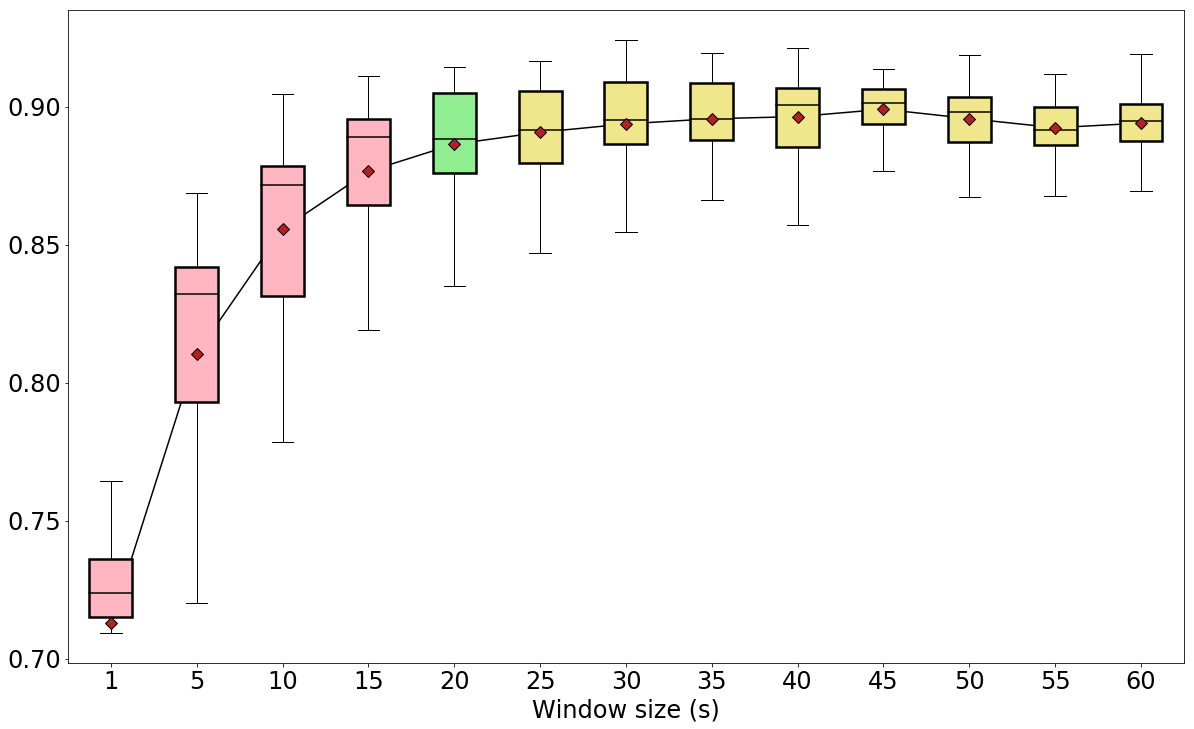

In [12]:
windows = [100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000]

dataTest2 = pd.DataFrame()
for i in windows:
    with open(baseWindows[0]+str(i)+"_"+'0 1 2 3 4 5 6 7 8 9 10 11 12 13'+'_167.csv','r') as f:
        dataTest2 = pd.concat([dataTest2,pd.read_csv(f,index_col=0,names=[i/100],skiprows=1)],axis = 1)

dataTest2Mean =  np.array(dataTest2.mean())

boxprops = dict(linewidth=2.5)
medianprops = dict(color='black', linewidth=1.5)


meanpointprops = dict(marker='D',markersize=8, markeredgecolor='black',
                      markerfacecolor='firebrick')
meanlineprops = dict(linestyle='--', linewidth=1.5, color='purple')

colors = ['lightpink','lightpink','lightpink','lightpink','lightgreen','khaki','khaki','khaki','khaki','khaki','khaki','khaki','khaki']

fig, ax = plt.subplots(figsize=(20,12))
bx=ax.boxplot(dataTest2.T,showfliers=False,patch_artist=True, boxprops=boxprops,medianprops=medianprops,meanprops=meanpointprops,showmeans=True)
for patch, color in zip(bx['boxes'], colors):
   patch.set_facecolor(color)

plt.yticks(fontsize = 24)
ax.set_xlabel('Window size (s)',fontsize = 24)
ax.set_xticklabels([1,5,10,15,20,25,30,35,40,45,50,55,60],fontsize = 24)

for i in range(len(dataTest2Mean)-1):
    plt.plot([i+1, i+2],[dataTest2Mean[i],dataTest2Mean[i+1]],'k-', lw=1.5)

## Figure 4

Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix


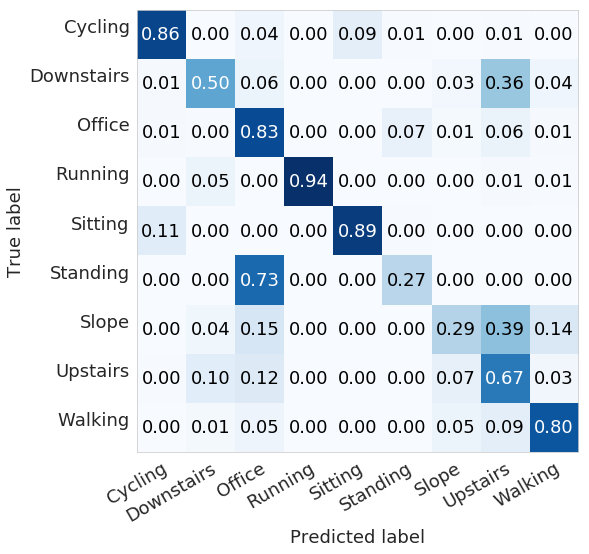

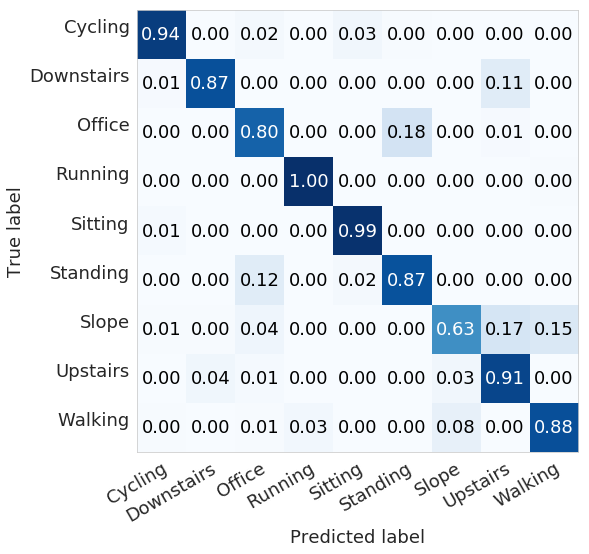

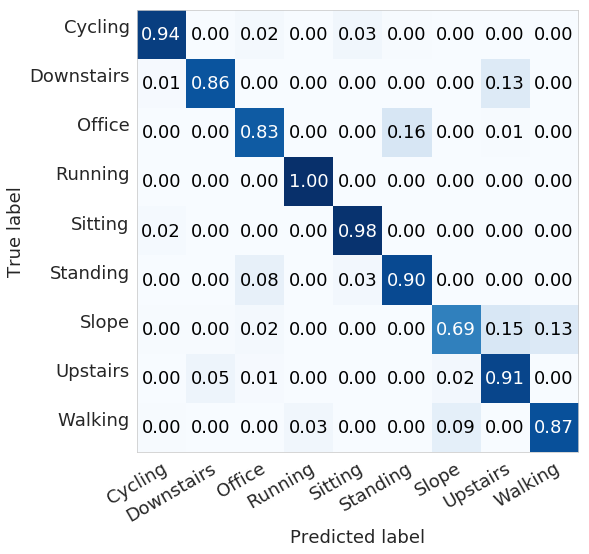

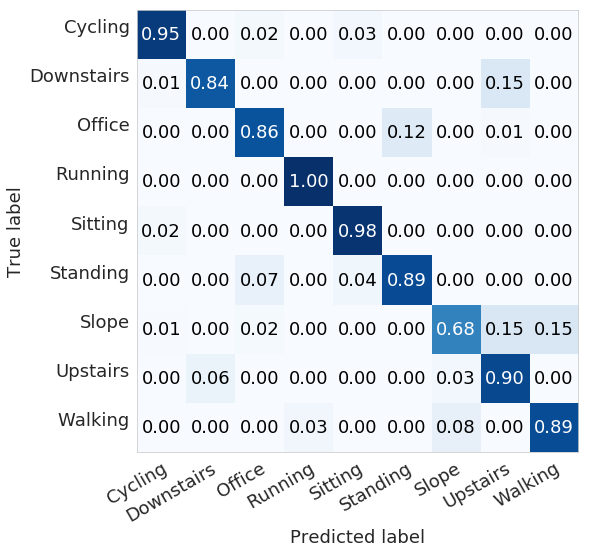

In [13]:
select_windowlength = [100, 2000, 3000, 4500]

for Win in select_windowlength:
    test = np.loadtxt(baseWindows[0]+ str(Win) +'_overall_true_pred_0 1 2 3 4 5 6 7 8 9 10 11 12 13_167.dat',delimiter=',')
    
    with sns.axes_style("whitegrid",{'axes.grid': False}):
        plot_conf_matrix_again(test,['Cycling', 'Downstairs', 'Office', 'Running', 'Sitting', 'Standing', 'Slope', 'Upstairs','Walking']) 

## Figure 5

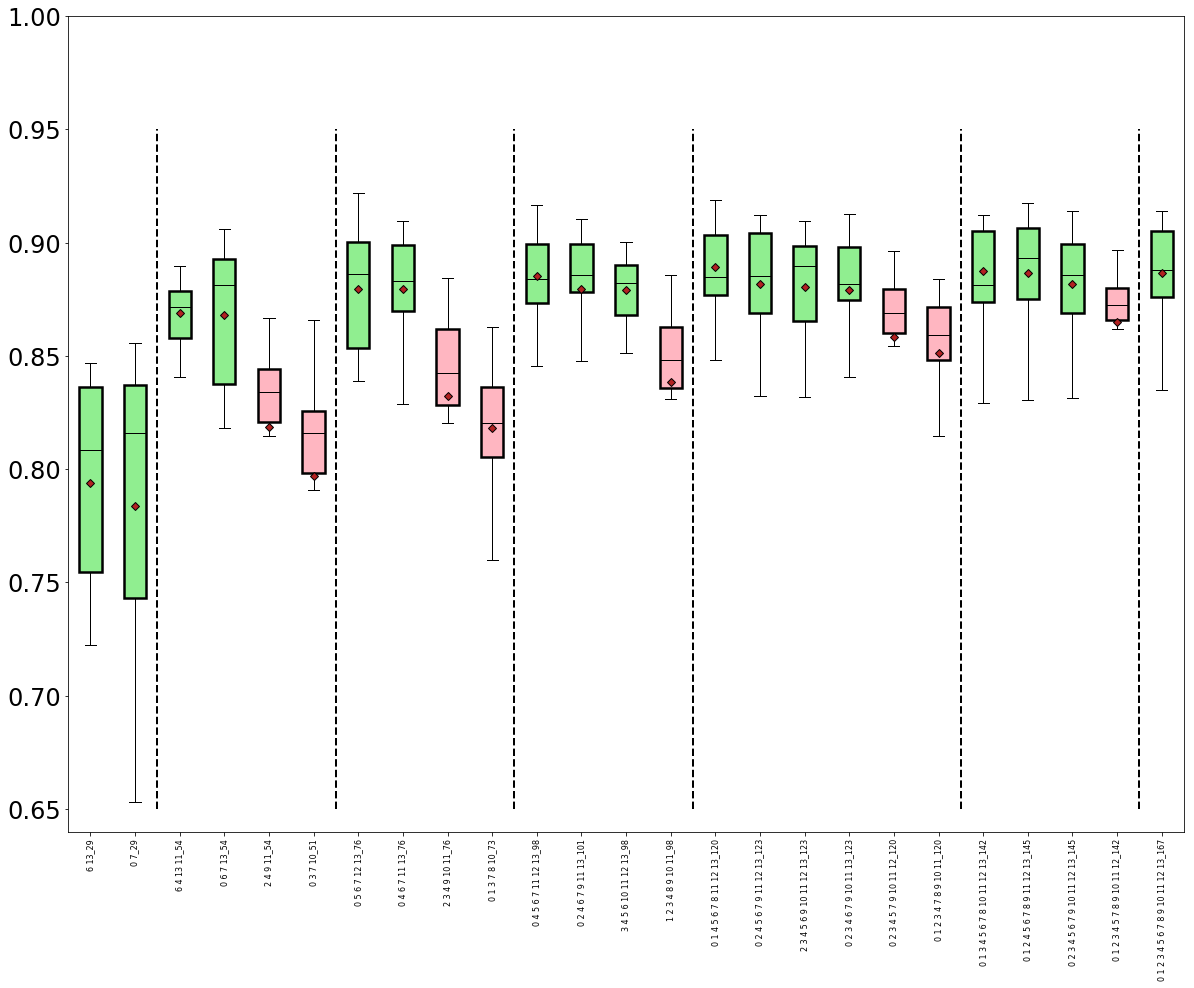

In [14]:
path = base+paths[0]
cols = ['6 13_29','0 7_29',
        '6 4 13 11_54','0 6 7 13_54','2 4 9 11_54','0 3 7 10_51',
        '0 5 6 7 12 13_76' ,'0 4 6 7 11 13_76','2 3 4 9 10 11_76','0 1 3 7 8 10_73',
        '0 4 5 6 7 11 12 13_98','0 2 4 6 7 9 11 13_101','3 4 5 6 10 11 12 13_98','1 2 3 4 8 9 10 11_98',
        '0 1 4 5 6 7 8 11 12 13_120','0 2 4 5 6 7 9 11 12 13_123','2 3 4 5 6 9 10 11 12 13_123','0 2 3 4 6 7 9 10 11 13_123','0 2 3 4 5 7 9 10 11 12_120',
        '0 1 2 3 4 7 8 9 10 11_120',
        '0 1 3 4 5 6 7 8 10 11 12 13_142', '0 1 2 4 5 6 7 8 9 11 12 13_145','0 2 3 4 5 6 7 9 10 11 12 13_145','0 1 2 3 4 5 7 8 9 10 11 12_142', 
        '0 1 2 3 4 5 6 7 8 9 10 11 12 13_167']

li = []
for each_column in cols:
    df_from_each_file = pd.read_csv(path+each_column+'.csv')
    del df_from_each_file['Unnamed: 0']
    li.append(df_from_each_file)
df_ConfigSelected = pd.concat(li, axis=1, sort=False)

boxprops = dict(linewidth=2.5)
medianprops = dict(color='black')

meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')

colors = ['lightgreen','lightgreen','lightgreen','lightgreen','lightpink','lightpink','lightgreen','lightgreen','lightpink','lightpink','lightgreen','lightgreen','lightgreen','lightpink','lightgreen','lightgreen','lightgreen','lightgreen','lightpink','lightpink','lightgreen','lightgreen','lightgreen','lightpink','lightgreen']

fig, ax = plt.subplots(figsize=(20,15))
bx=ax.boxplot(df_ConfigSelected.T,showfliers=False,patch_artist=True,boxprops=boxprops,medianprops=medianprops,meanprops=meanpointprops,showmeans=True)
ax.set_xticklabels(cols,rotation=90,fontsize = 8)
plt.yticks(fontsize = 24)
ax.set_ylim(bottom = 0.64,top=1.0)
plt.plot([2.5, 2.5],[0.65,0.95],'k--', lw=2)
plt.plot([6.5, 6.5],[0.65,0.95],'k--', lw=2)
plt.plot([10.5, 10.5],[0.65,0.95],'k--', lw=2)
plt.plot([14.5, 14.5],[0.65,0.95],'k--', lw=2)
plt.plot([20.5, 20.5],[0.65,0.95],'k--', lw=2)
plt.plot([24.5, 24.5],[0.65,0.95],'k--', lw=2)
for patch, color in zip(bx['boxes'], colors):
   patch.set_facecolor(color)

## Figure 6

Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix


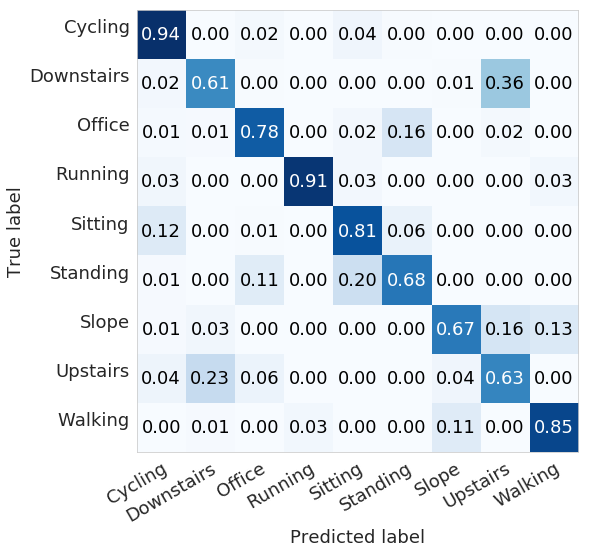

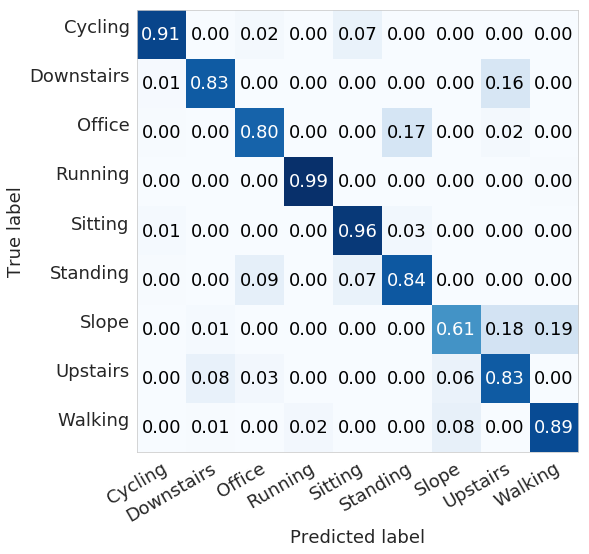

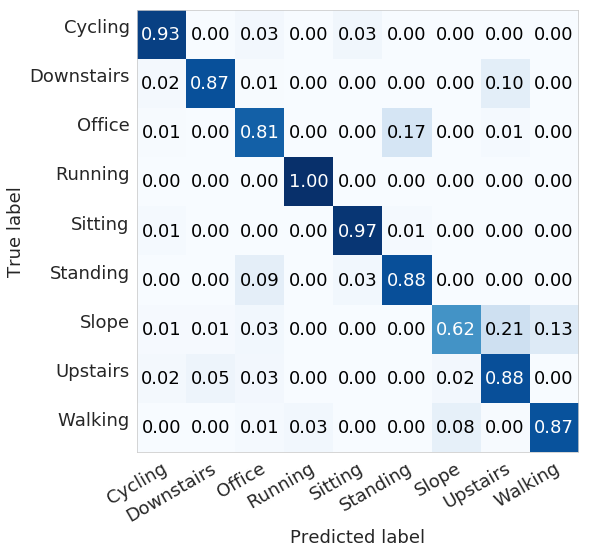

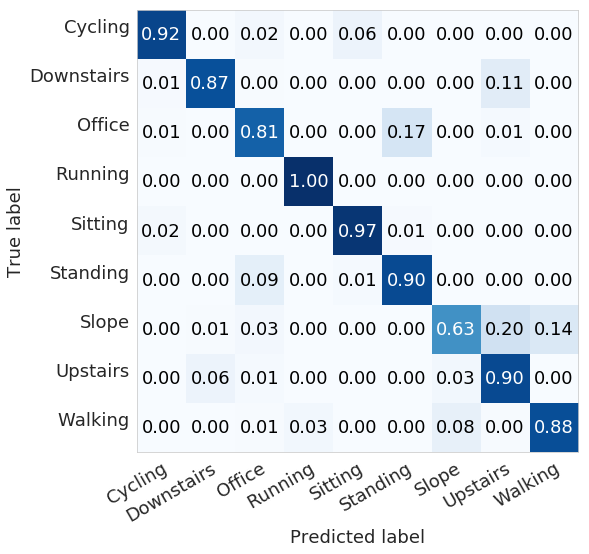

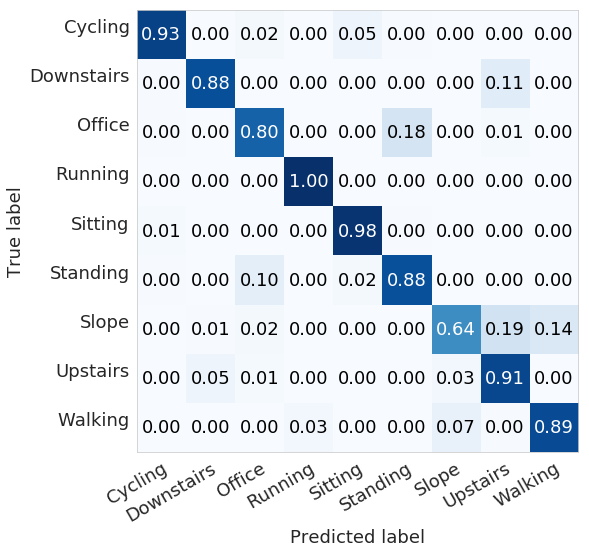

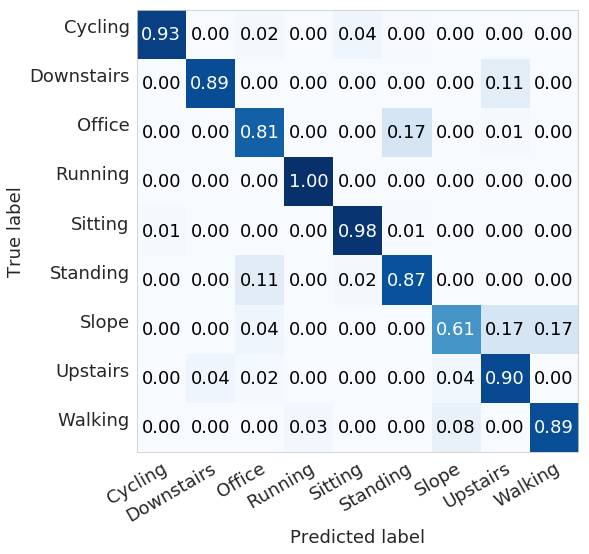

In [15]:
cols = ['6 13_29',
        '6 4 13 11_54',
        '0 5 6 7 12 13_76',
        '0 4 5 6 7 11 12 13_98',
        '0 1 4 5 6 7 8 11 12 13_120',
        '0 1 3 4 5 6 7 8 10 11 12 13_142']

li = []
name = 0
for each_column in cols:
    test = np.loadtxt(path+'overall_true_pred_'+each_column+'.dat',delimiter=',')
    
    with sns.axes_style("whitegrid",{'axes.grid': False}):
        plot_conf_matrix_again(test,['Cycling', 'Downstairs', 'Office', 'Running', 'Sitting', 'Standing', 'Slope', 'Upstairs','Walking'])        
        
    name += 1

## Figure 7

Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix


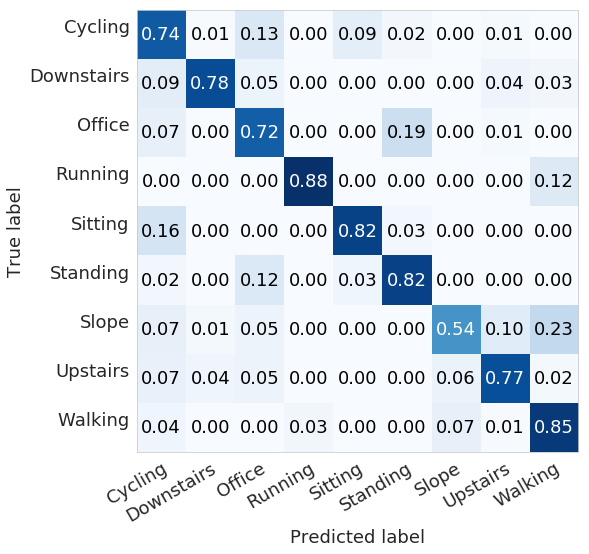

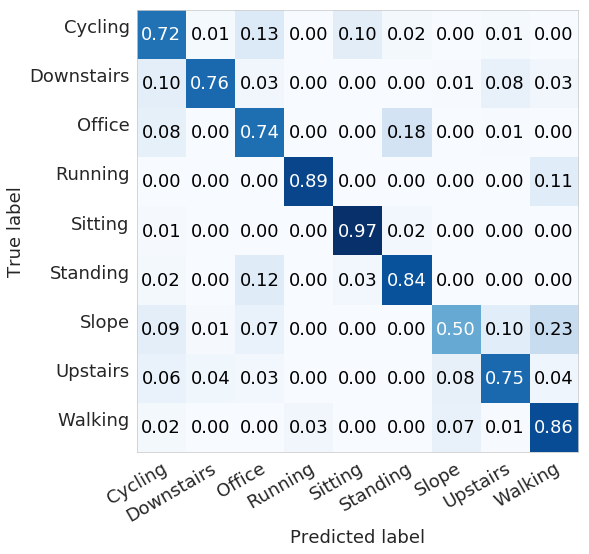

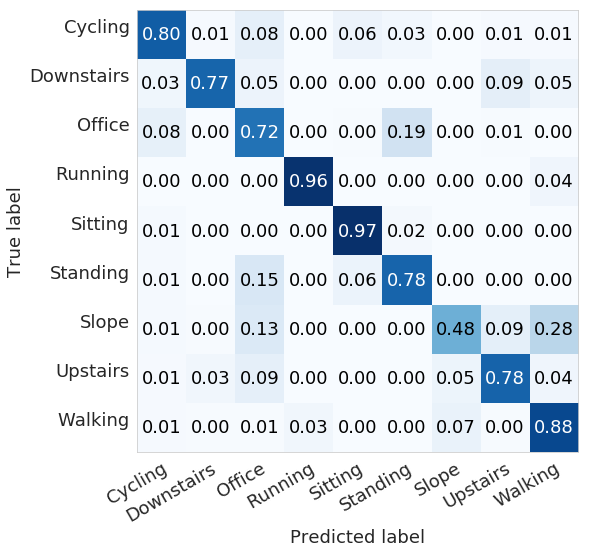

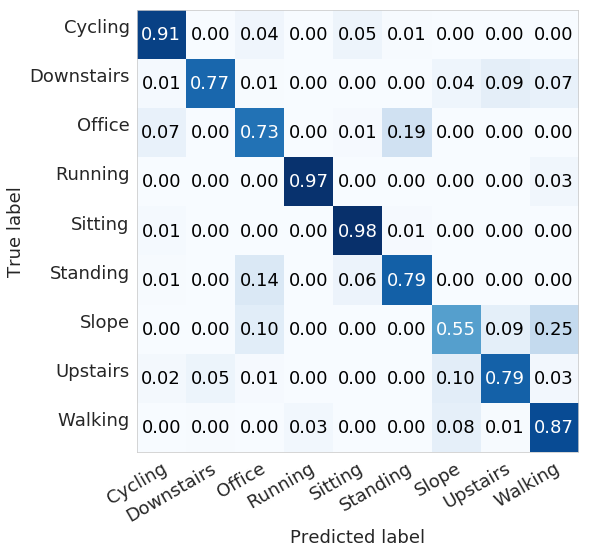

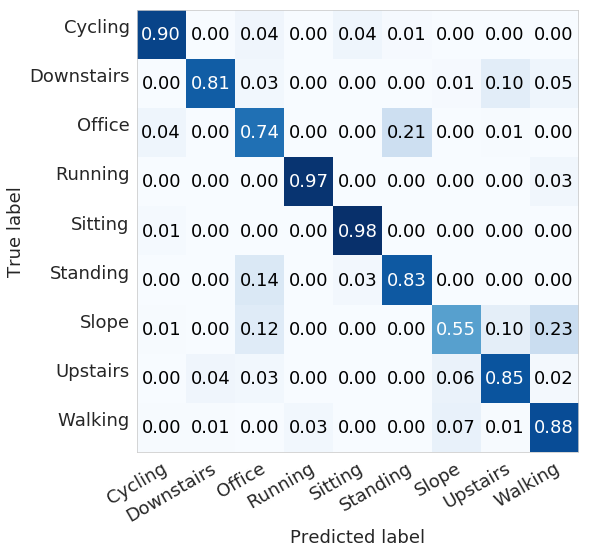

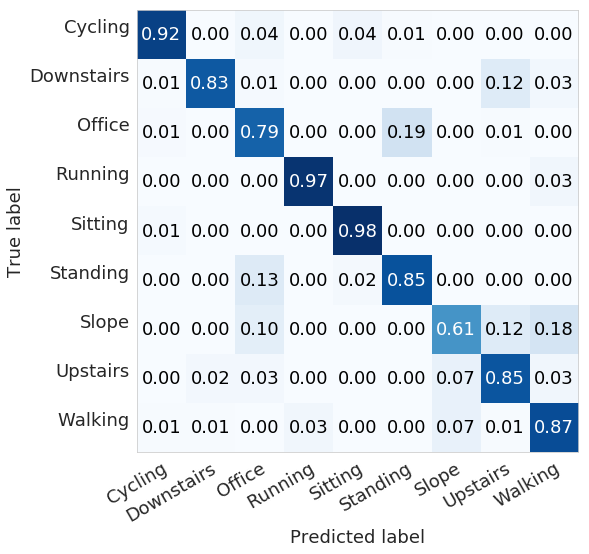

In [16]:
cols = ['0 7_29',
        '0 3 7 10_51',
        '0 1 3 7 8 10_73',
        '1 2 3 4 8 9 10 11_98',
        '0 1 2 3 4 7 8 9 10 11_120',
        '0 1 2 3 4 5 7 8 9 10 11 12_142']

li = []
name = 0
for each_column in cols:
    test = np.loadtxt(path+'overall_true_pred_'+each_column+'.dat',delimiter=',')
    
    with sns.axes_style("whitegrid",{'axes.grid': False}):
        plot_conf_matrix_again(test,['Cycling', 'Downstairs', 'Office', 'Running', 'Sitting', 'Standing', 'Slope', 'Upstairs','Walking'])        
        
    name += 1

## Figure 8

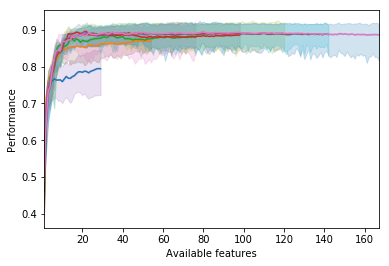

NEXT       :  [6, 13]


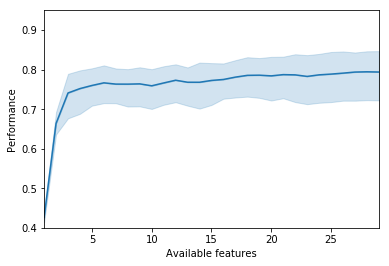

NEXT       :  [6, 4, 13, 11]


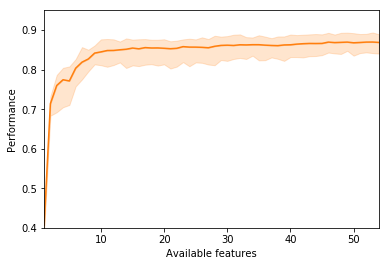

NEXT       :  [0, 5, 6, 7, 12, 13]


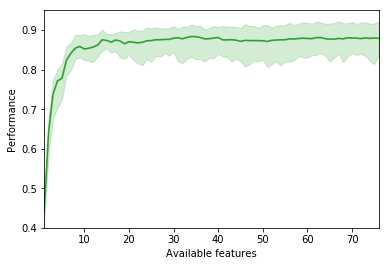

NEXT       :  [0, 4, 5, 6, 7, 11, 12, 13]


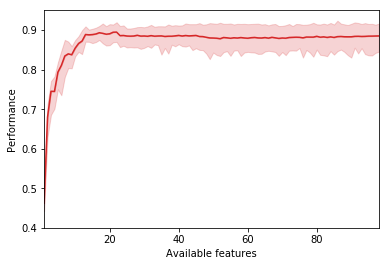

NEXT       :  [0, 1, 4, 5, 6, 7, 8, 11, 12, 13]


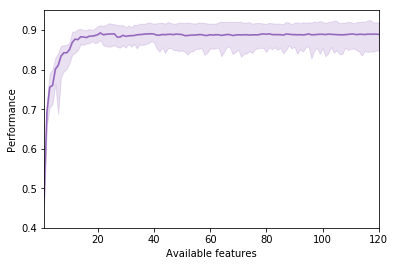

NEXT       :  [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13]


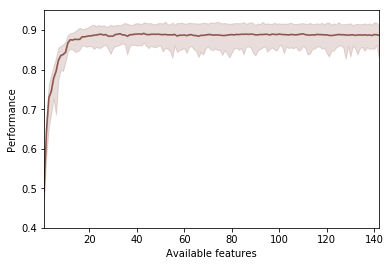

NEXT       :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


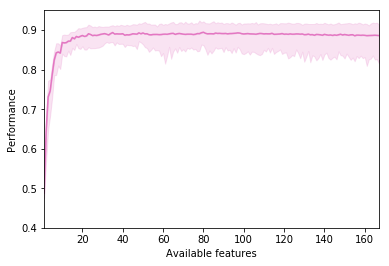

In [17]:
ofInterest = [[6,13],
              [6, 4, 13, 11], # For (4,6,11,13) listed 6,4,13,11 in the data
              [0,5,6,7,12,13],
              [0,4,5,6,7,11,12,13],
              [0,1,4,5,6,7,8,11,12,13],
              [0,1,3,4,5,6,7,8,10,11,12,13],
              list(range(14))]

# Plot curve all together
plot_min_max(getAllData(base+paths[-1],sensor_list_to_str(ofInterest)), basename = 'id')

#plot each curve separately
colorIndex = 0
for i in range(len(ofInterest)):
    print('NEXT       : ', ofInterest[i])
    da = getAllData(base+paths[-1],sensor_list_to_str([ofInterest[i]]))
    basename = 'id'
    adapted = getStats(da,basename) # selected data for plot, out of da.
    
    # Getting the color palette
    palette = sns.color_palette()
    
    # Plot base line
    line = adapted.loc[:,('value', 'mean')].plot(color=palette[colorIndex%len(palette)])
    line.set_xlabel('Available features')
    line.set_ylabel('Performance')
    line.get_legend().remove()

    
    for indexName in adapted.loc[:,('value', 'mean')].columns:
        line.fill_between(adapted.index, adapted.loc[:,('value', 'mean', indexName)],
                adapted.loc[:,('value', 'max', indexName)], alpha=.2, color=palette[colorIndex%len(palette)])
        line.fill_between(adapted.index, adapted.loc[:,('value', 'min', indexName)] ,
                adapted.loc[:,('value', 'mean', indexName)], alpha=.2, color=palette[colorIndex%len(palette)])
        colorIndex += 1
    line.set(ylim=(0.4, 0.95))
    plt.show()

## Figure 9
<p> The final figure panel has not been edited with matplotlib. Only the table is generated here.
<br> Feature names might differ compared to the manuscript.
</p>

In [18]:
lii = []

for conf in ofInterest:
    print(conf)   
    
    lii.append(getAllFeatures(base+paths[0],conf))

Feat = []
jj=0
track = 0
Table = pd.DataFrame(columns=['1','2','3','4','5','6','7'])
for dd in range(len(lii)):
    temp = []
    for jj in range(len(lii[dd])):
        feat_nb = len(lii[dd])-jj
        if feat_nb < 21:           
            Feat = lii[dd].iloc[jj].idxmin()
            temp.append(Feat)
        if feat_nb == 1:
            Table[str(track+1)] = temp
    track +=1
Table

[6, 13]
[6, 4, 13, 11]
[0, 5, 6, 7, 12, 13]
[0, 4, 5, 6, 7, 11, 12, 13]
[0, 1, 4, 5, 6, 7, 8, 11, 12, 13]
[0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


,1,2,3,4,5,6,7
0,midR1,peakmgstdR3,peakdisstdL7,stdL2,aveR7,peaknumR6,stdL2
1,stdR1,maxL1,stdR7,peakwthaveR2,peaknumR6,peakdisaveL1,peaknumR7
2,peakmgstdL1,stdL3,peakwthaveR2,aveR7,peaknumL2,aveR7,stdL7
3,peakwthstdR1,peakwthaveL1,peakmgaveR1,peakmgaveR1,peakmgaveR1,peakdisstdL7,peaknumL7
4,peakdisaveR1,peakmgaveR1,peakdisaveL1,peaknumR7,peaknumR7,peaknumR7,peakdisaveL1
5,peakwthstdL1,peakdisaveR1,aveR7,peakdisaveL1,peakdisaveL1,peakwthaveR2,inerstepinterval
6,fftennergy,aveL1,peakdisstdR7,peaknumL2,inerstepinterval,peakmgaveR1,maxR5
7,midL1,maxR3,peaknumR7,peakdisstdR7,fftennergy,peaknumL2,peaknumR1
8,peakmgaveR1,peakdisaveR3,stdL2,aveL7,aveL7,aveL7,peakmgaveR1
9,peakwthaveR1,peakdisaveL1,peaknumL2,inerstepinterval,peakdisstdR7,peakdisstdR7,peaknumL2


## Figure 10

Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix


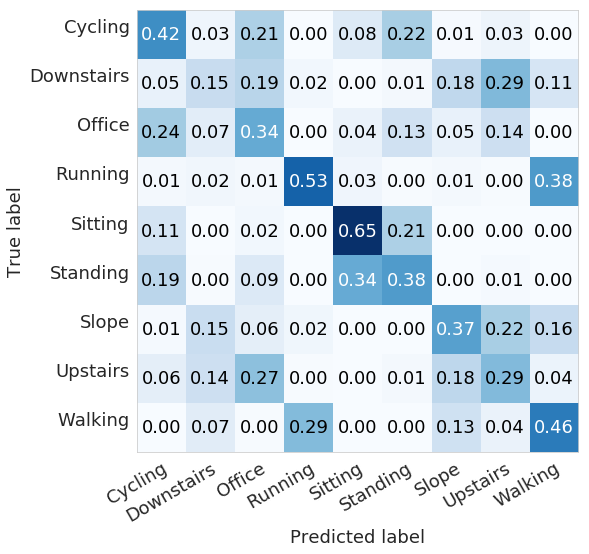

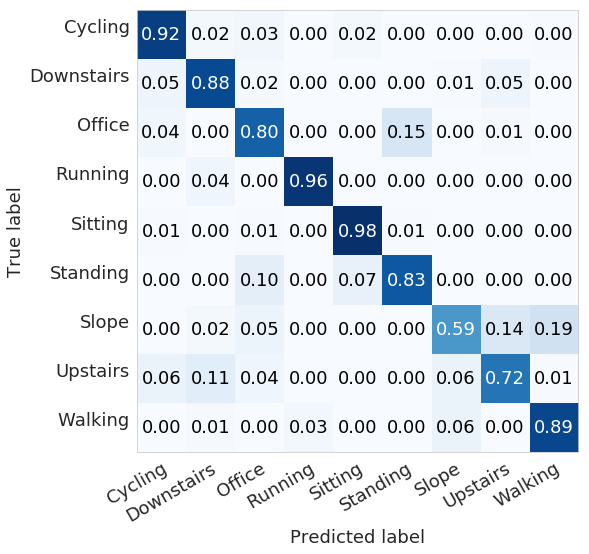

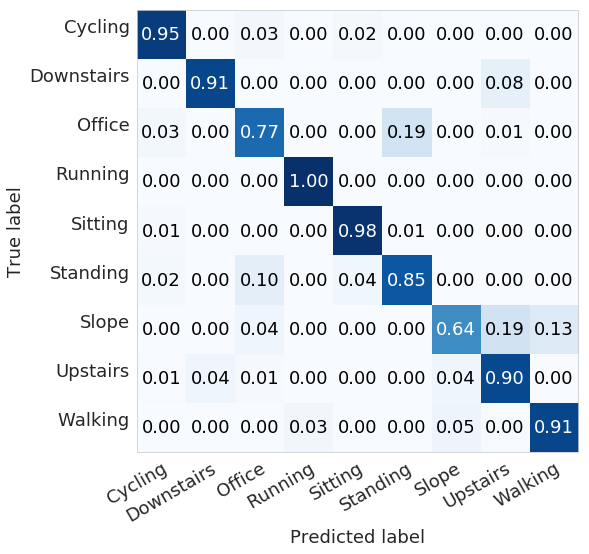

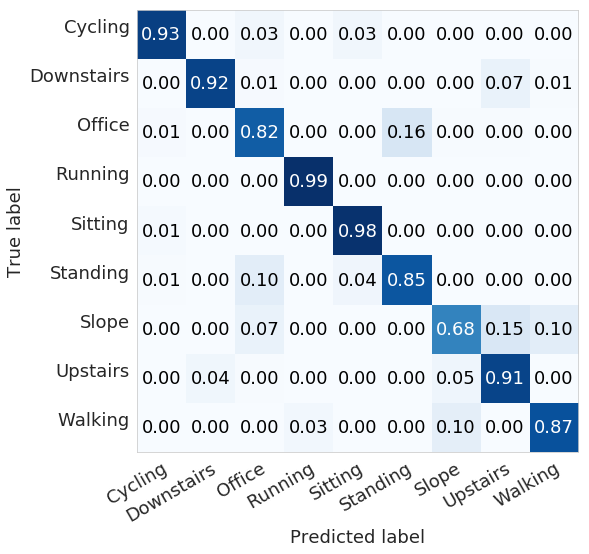

In [19]:
select_ma = ['*6 13*_1', '*0 5 6 7*_9', '*0 1 4 5 6 7*_21', '*0 1 2 3 4 5 6 7*_23' ]


panel = 0
for ma in select_ma:
    panel +=1
    test = np.loadtxt(glob.glob(base+paths[0]+ma+'.dat')[0],delimiter=',')
    with sns.axes_style("whitegrid",{'axes.grid': False}):
        plot_conf_matrix_again(test,['Cycling', 'Downstairs', 'Office', 'Running', 'Sitting', 'Standing', 'Slope', 'Upstairs','Walking'])

## Figure 11

*0 4 5 6 7 11 12 13_22_44.dat
Normalized confusion matrix
*0 4 5 6 7 11 12 13_29_66.dat
Normalized confusion matrix
*0 4 5 6 7 11 12 13_86_59.dat
Normalized confusion matrix
*0 4 5 6 7 11 12 13_49_17.dat
Normalized confusion matrix


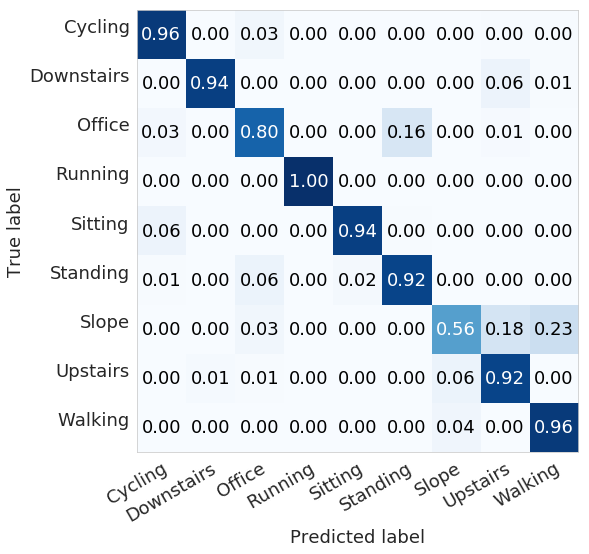

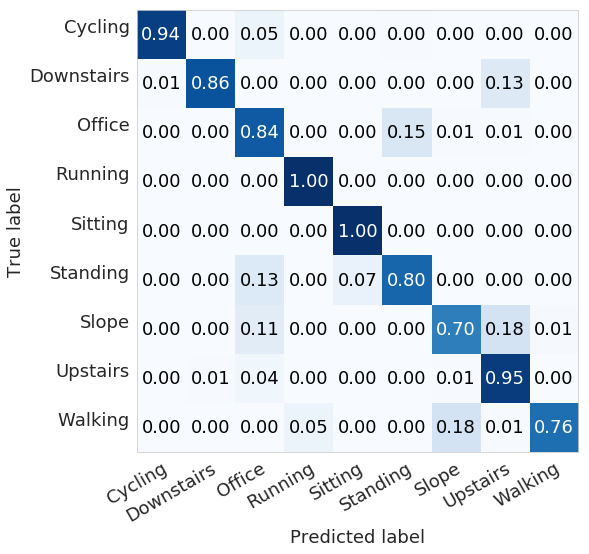

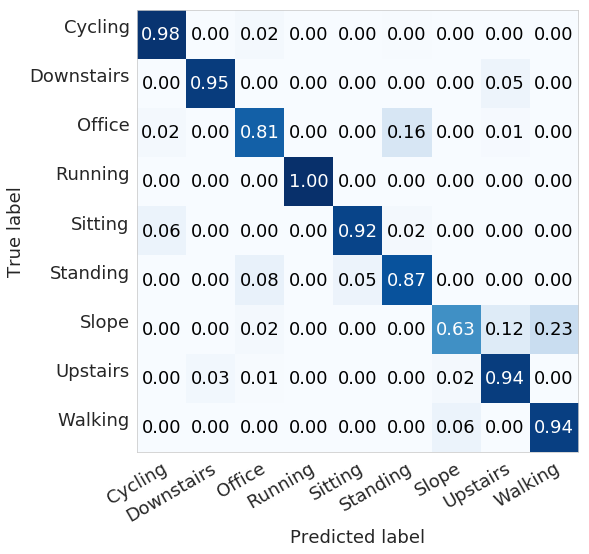

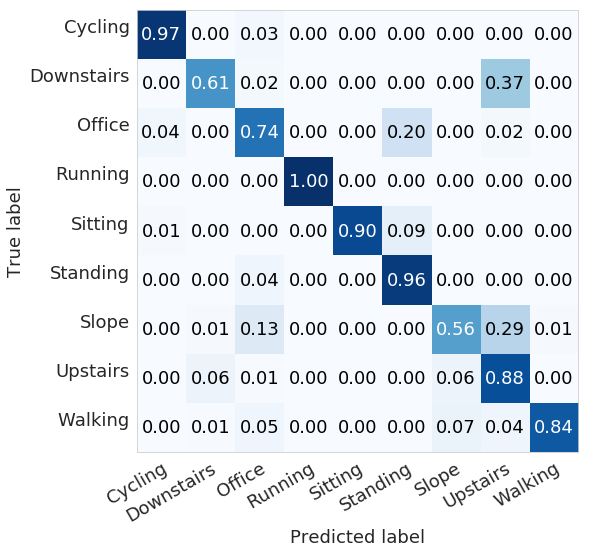

In [20]:
# selected config
oneConfig = np.array([0, 4, 5, 6, 7, 11, 12, 13])
# get stats
someStats = [[getStats(getAllData(base+p,sensor_list_to_str(conf)),'id') for conf in [[oneConfig]]] for p in paths]
# best and worst forest selected manually
# comment out the following to repeat the exploration
# someStats[0][0].loc[30:,('value','min')] # allow identifying the worst forest for a number of >30 features
# someStats[0][0].loc[30:,('value','max')] # allow identifying the best forest for a number of >30 features
# someStats[0][0].loc[15:30,('value','min')] # allow identifying the worst forest for a number of features between 15 and 30
# someStats[0][0].loc[15:30,('value','max')] # allow identifying the best forest for a number of features between 15 and 30
BestWorst = []
BestForest_R = someStats[0][0].loc[30:,('value','max')].max()
BestWorst.append(BestForest_R[0])
WorstForest_R = someStats[0][0].loc[30:,('value','min')].min()
BestWorst.append(WorstForest_R[0])
BestForest_L = someStats[0][0].loc[15:30,('value','max')].max()
BestWorst.append(BestForest_L[0])
WorstForest_L = someStats[0][0].loc[15:30,('value','min')].min()
BestWorst.append(WorstForest_L[0])
#location of the best and worst forests
select_nbft = ['0 4 5 6 7 11 12 13_22', # Best
               '0 4 5 6 7 11 12 13_29', # Worst
               '0 4 5 6 7 11 12 13_86', #Best
               '0 4 5 6 7 11 12 13_49' #Worst
              ]
# build a path
l = []
for w in select_nbft:
    t = pd.read_csv(base+paths[0]+w+'.csv')
    forest_nb = 0
    for i in t.iloc[:,1]:
        if i == BestWorst[0] or i == BestWorst[1] or i == BestWorst[2] or i == BestWorst[3]:
            #print(forest_nb)
            l.append('*'+w+'_'+str(forest_nb)+'.dat')
        forest_nb +=1
#compute the panels
panel = 0
for ma in l:
    panel +=1
    print(ma)
    test = np.loadtxt(glob.glob(base+npaths[0]+ma)[0],delimiter=',')
    with sns.axes_style("whitegrid",{'axes.grid': False}):
        plot_conf_matrix_again(test,['Cycling', 'Downstairs', 'Office', 'Running', 'Sitting', 'Standing', 'Slope', 'Upstairs','Walking'])

### Sensor ID chart

#### In the paper
<p> heel = 1
<br> latereal midfoot = 2
<br> center of midfoot = 3
<br> lateral forefoot = 4
<br> center of forefoot = 5
<br> medial forefoot = 6
<br> big toe = 7
</p> 

#### In this notebook
##### Left foot
<p> heel = 6
<br> latereal midfoot = 5
<br> center of midfoot = 1
<br> lateral forefoot = 4
<br> center of forefoot = 0
<br> medial forefoot = 2
<br> big toe = 3
</p> 

##### Left foot
<p> heel = 13
<br> latereal midfoot = 12
<br> center of midfoot = 8
<br> lateral forefoot = 11
<br> center of forefoot = 7
<br> medial forefoot = 9
<br> big toe = 10
</p> 

#### In "**automatedAnalysis.py**" (and output of Fig 9 in this notebook, see Table)
<p> heel = 1
<br> latereal midfoot = 2
<br> center of midfoot = 6
<br> lateral forefoot = 3
<br> center of forefoot = 7
<br> medial forefoot = 5
<br> big toe = 4
<br> with "L" for left, "R" for right
</p> 

